In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import t
from sklearn.linear_model import LinearRegression
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from typing import Callable, Tuple
from tqdm import tqdm
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats

## Variable Exclusion Test

Let's consider a nonlinear regression problem.
Our data is $(y_i, x_{i1},x_{i2},\dots, x_{ip})$, $i=1,\dots, n$. 

The true model is:

$y_i = 5\sin(x_{i1}) + \varepsilon_i, \quad \varepsilon_i\sim t_{100}.$

That is, only one of the $p$ predictors is important for predicting $y$.

In [2]:
n = 1000
p = 50
x = np.random.uniform(-10,10, size=(n, p))
y = 5 * np.sin(x[:, 0]) + t.rvs(100, size=n)

Here is the plot of $y_i$ vs. $x_{i1}$.

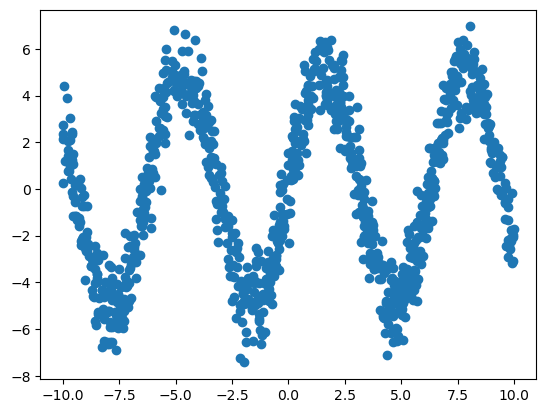

In [3]:
plt.scatter(x[:, 0], y)

Here is the plot of $y_i$ vs. $x_{i2}$ (which has no relationship!)

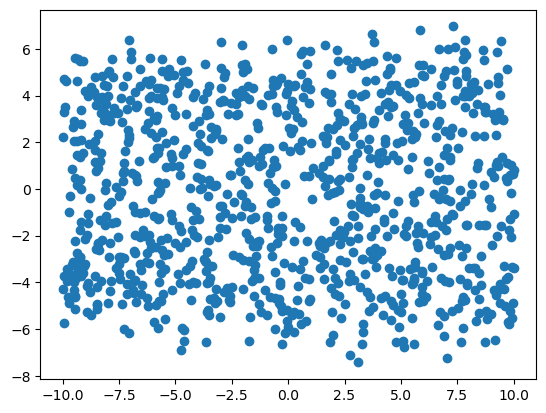

In [4]:
plt.scatter(x[:, 1], y)

Let's fit a linear regression to this data.

In [5]:
lm = LinearRegression()
lm.fit(x, y)
y_hat = lm.predict(x)
resid = y - y_hat

Our coefficients are very small, as we may expect (fitting a linear function to nonlinear data).

In [6]:
print('Intercept:', round(lm.intercept_, 3),'\n', 'Slope:', round(lm.coef_[0],3))

Intercept: -0.183 
 Slope: 0.13


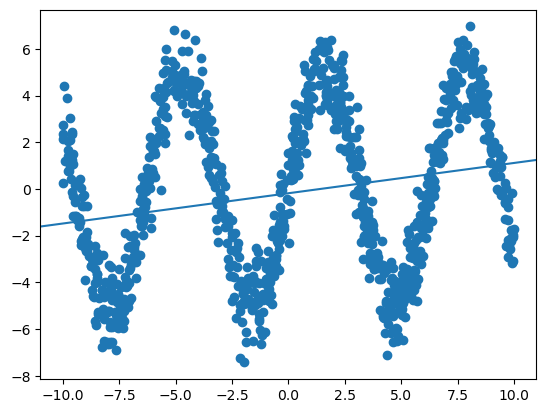

In [7]:
plt.scatter(x[:,0], y)
plt.axline((0,lm.intercept_), slope=lm.coef_[0])

Let's train a nonlinear model instead (gradient boosted trees, XGBoost).

In [8]:
n_train = int(n/2)
x_train = x[:n_train]
x_test = x[n_train:]
y_train = y[:n_train]
y_test = y[n_train:]

In [9]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

params = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 4
}

# Train the model (suppress training output)
num_rounds = 100
eval_list = [(dtrain, 'train'), (dtest, 'eval')]
model_with = xgb.train(params, dtrain, num_rounds, eval_list, early_stopping_rounds=10, verbose_eval=False)

/Users/gm845/anaconda3/envs/msds534/lib/python3.13/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [10]:
# make predictions
y_pred_with = model_with.predict(dtest)
# z
resid_with = np.power(y_test - y_pred_with, 2)

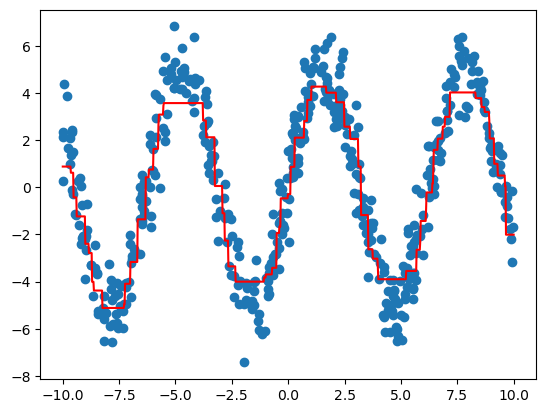

In [11]:
n_lin = 1000
x_linspace = np.linspace(x_train.min(), x_train.max(), n_lin).reshape(n_lin, 1)
x_linspace = np.hstack((x_linspace, np.zeros((n_lin, p-1))))
y_linspace = model_with.predict(xgb.DMatrix(x_linspace))
plt.scatter(x_test[:, 0], y_test)
plt.plot(x_linspace[:, 0], y_linspace, c='red')

We will conduct a "Variable Exclusion Test" to test the contribution of $x_{i1}$ in predicting $y_i$.

Our null hypothesis is:

$H_0: \mathbb{E}[y_i|x_{i1},\dots, x_{ip}] = \mathbb{E}[y_i|x_{i2},x_{i3},\dots,x_{ip}]$

On the training data, we train two models:

- $f(x_{i1},x_{i2},\dots, x_{ip})$ to predict $y_i$
- $g(x_{i2}, x_{i3},\dots, x_{ip})$ to predict $y_i$

For each $i$, we calculate:

- $z_i = y_i - f(x_{i1},x_{i2},\dots, x_{ip})$ 
- $\widetilde{z}_i = y_i - g(x_{i2},x_{i3},\dots, x_{ip})$ 

Our test-statistic is:
$T_{obs} = \frac{1}{n}\sum_{i=1}^n (z_i - \widetilde{z}_i)$

To get the null distribution of $T$, for $b=1,\dots, B$:

- Swap $z_i$ and $\widetilde{z}_i$ with probability 0.5. This gives $z_{i}^{(b)}$ and $\widetilde{z}_i^{(b)}$
- Calculate $T^{(b)}=\frac{1}{n}\sum_{i=1}^n (z_i^{(b)} - \widetilde{z}_i^{b})$

The $p$-value is:

$p-\text{value} = \frac{1}{B}\sum_{b=1}^B I(T^{(b)} \leq T_{obs})$

In [12]:
# we have trained f already
# now train g
dtrain = xgb.DMatrix(x_train[:, range(1, p)], label=y_train)
dtest = xgb.DMatrix(x_test[:, range(1, p)], label=y_test)

params = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 4
}

# Train the model
num_rounds = 100
eval_list = [(dtrain, 'train'), (dtest, 'eval')]
model_without = xgb.train(params, dtrain, num_rounds, eval_list, early_stopping_rounds=10,verbose_eval=False)

In [13]:
y_pred_without = model_without.predict(dtest)
# ~z
resid_without = np.power(y_pred_without - y_test, 2)

In [14]:
n_test = y_test.shape[0]

In [15]:
print(f"Mean Test Errors: {resid_with.mean():.4f}")
print(f"Mean Null Test Errors: {resid_without.mean():.4f}")

obs_T = resid_with.mean() - resid_without.mean()

Mean Test Errors: 1.3923
Mean Null Test Errors: 12.8082


In [16]:
# get columns Z | Z_tilde
resid_all = np.hstack((resid_with.reshape(n_test, 1), resid_without.reshape(n_test, 1)))

In [17]:
n_permutations = 500
resampled_Ts = []

for _ in range(n_permutations):
    heads = np.random.choice(np.array((0,1)), size=n_test)

    resamp_with = resid_all[range(n_test), heads]
    resamp_without = resid_all[range(n_test), 1-heads]
    # test error using X - test error not using X
    resampled_T = np.mean(resamp_with) - np.mean(resamp_without)
    resampled_Ts.append(resampled_T)

## Calculate p-value
p_value = sum([1 for t in resampled_Ts if t <= obs_T]) / n_permutations

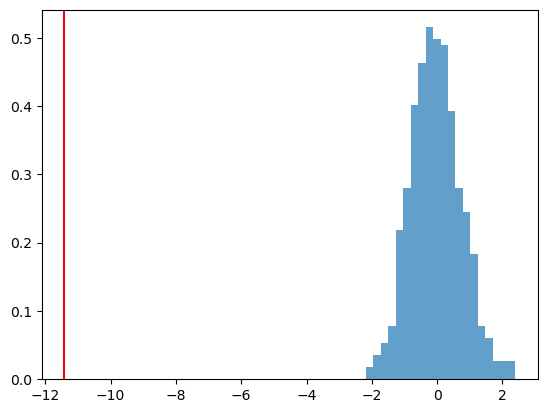

P-Value: 0.0000


In [18]:
resampled_Ts = np.array(resampled_Ts)
plt.hist(resampled_Ts, bins=20 ,density=True, alpha=0.7)
plt.axvline(obs_T, color='red')
plt.show()

print(f"P-Value: {p_value:.4f}")


We reject the null hypothesis. 

Now let's do the test for $x_{i2}$, which we know has no relationship with $y_i$.

In [19]:
j = 1
x_js = np.array([i for i in range(p) if i != j])

In [20]:
x_js

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [21]:
dtrain = xgb.DMatrix(x_train[:, x_js], label=y_train)
dtest = xgb.DMatrix(x_test[:, x_js], label=y_test)

params = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 4
}

# Train the model
num_rounds = 100
eval_list = [(dtrain, 'train'), (dtest, 'eval')]
model_without = xgb.train(params, dtrain, num_rounds, eval_list, early_stopping_rounds=10,verbose_eval=False)

y_pred_without = model_without.predict(dtest)
resid_without = np.power(y_pred_without - y_test, 2)

In [22]:
print(f"Mean Test Errors: {resid_with.mean():.4f}")
print(f"Mean Null Test Errors: {resid_without.mean():.4f}")

obs_T = resid_with.mean() - resid_without.mean()

Mean Test Errors: 1.3923
Mean Null Test Errors: 1.4237


In [23]:
resid_all = np.hstack((resid_with.reshape(n_test, 1), resid_without.reshape(n_test, 1)))

n_permutations = 1000
resampled_Ts = []

for _ in range(n_permutations):
    heads = np.random.choice(np.array((0,1)), size=n_test)

    resamp_with = resid_all[range(n_test), heads]
    resamp_without = resid_all[range(n_test), 1-heads]
    # test error using X - test error not using X
    resampled_T = np.mean(resamp_with) - np.mean(resamp_without)
    resampled_Ts.append(resampled_T)

## Calculate p-value
p_value = sum([1 for t in resampled_Ts if t <= obs_T]) / n_permutations

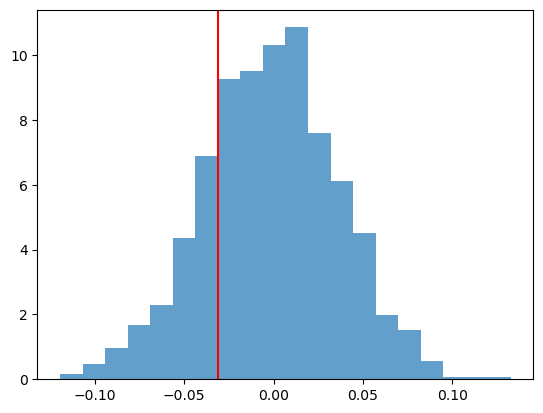

P-Value: 0.2110


In [24]:
resampled_Ts = np.array(resampled_Ts)
plt.hist(resampled_Ts, bins=20, density=True, alpha=0.7)
plt.axvline(obs_T, color='red')
plt.show()

print(f"P-Value: {p_value:.4f}")

We do not reject the null hypothesis (as expected).

## Conditional Randomization Test


We generate a new dataset:

$Z_{i1} \sim N(0, 1), Z_{i2}\sim N(0,1)$

$X_i = Z_{i1} + N(0, 0.1^2)$

$Y_i = 0.4 X_{i} + 0.4 Z_{i2} + N(0, 0.5^2)$

- $X_i$ is correlated with $Z_{i1}$.
- Only $X_i$ and $Z_{i2}$ are predictive of $Y_i$

In [25]:
# Generate example data
np.random.seed(42)
n_samples = 1000

# Generate confounding variable Z
Z = np.random.normal(0, 1, (n_samples, 2))

# Generate X with dependence on Z
x_sd = 0.2
X = Z[:, 0] + np.random.normal(0, x_sd, n_samples)

# Generate Y with dependence on both X and Z
# X, Z1, Z2
Y = 0.5 * X + 0.5 * Z[:, 1] + np.random.normal(0, 0.5, n_samples)

We run a linear regression and obtain estimates of our coefficients for $X$, $Z_1$ and $Z_2$. 

We also conduct a $t$-test for each variable - as expected, we see for $X$, $Z_2$ we reject the null that the coefficient is zero. For $Z_1$ we retain the null hypothesis. 

In [26]:
dat = np.hstack((X.reshape(-1,1), Z))
est = sm.OLS(Y, dat)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.642
Model:                            OLS   Adj. R-squared (uncentered):              0.641
Method:                 Least Squares   F-statistic:                              596.5
Date:                Tue, 25 Nov 2025   Prob (F-statistic):                   6.32e-222
Time:                        15:13:12   Log-Likelihood:                         -750.23
No. Observations:                1000   AIC:                                      1506.
Df Residuals:                     997   BIC:                                      1521.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In linear regression, the $t$-test for $H_0:\beta_j=0$ is testing whether $x_j$ is independent of $y$, conditional on $(x_1,\dots, x_{j-1}, x_{j+1}, \dots, x_p)$, if we make assumptions of linearity and Gaussianity.

What if we do not want to make these assumptions? We can conduct a conditional randomization test:

$H_0: X_j \text{ ind } Y | X_1,\dots, X_{j-1}, X_{j+1}, \dots X_p$

Conditional Randomization Test (Candes et al. 2018)

- On observed data, calculate $T_{obs}$
- For $b=1,\dots, B$:
    - Draw $X_j^{(b)} \sim Q(X_j|X_{\backslash j})$
    - Calculate $T^{(b)}$ based on $Y_i, X_j^{(b)}, X_{\backslash j}$
- Calculate $p$-value:

$\frac{1}{B}\sum_{b=1}^B I(T^{(b)} \geq T_{obs})$

In this example, we use the true $Q(X|Z)$ distribution. In practice, we do not know this distribution - we generally have to estimate it.

In [27]:
B = 1000

# Compute observed test statistic
observed_stat = est2.params[0]

# Perform sampling
null_stats = np.zeros(B)

for i in tqdm(range(B)):
    # sample conditional x
    X_draw = np.zeros_like(X)
    for j in range(len(X)):
        # Draw from conditional distribution
        X_draw[j] = Z[j, 0] + np.random.normal(0, x_sd) # this is the true conditional distribution

# Compute test statistic for permuted data
    dat = np.hstack((X_draw.reshape(-1,1), Z))
    est = sm.OLS(Y, dat)
    est2 = est.fit()

    null_stats[i] = est2.params[0]

# Compute p-value
p_value = np.mean(np.abs(null_stats) >= np.abs(observed_stat))
        

100%|██████████| 1000/1000 [00:00<00:00, 1341.46it/s]



Conditional Randomization Test Results:
Observed Statistic: 0.5610
P-value: 0.0000


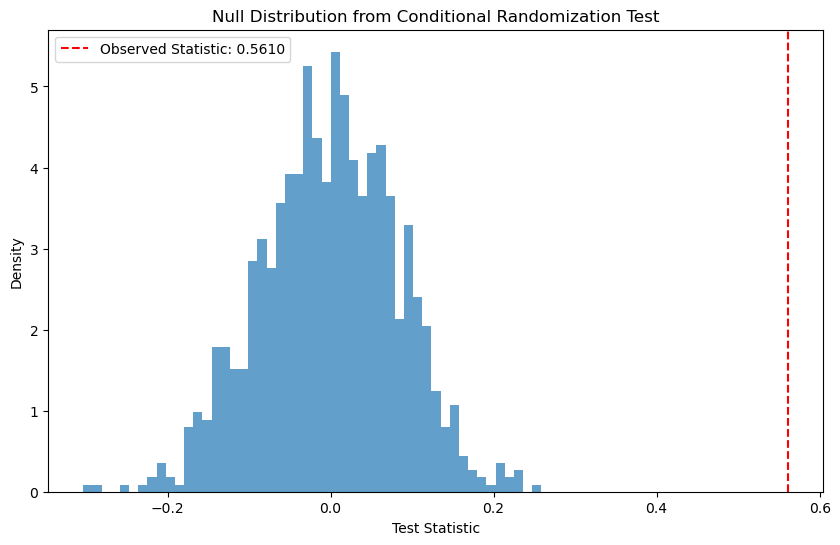

In [28]:
print("\nConditional Randomization Test Results:")
print(f"Observed Statistic: {observed_stat:.4f}")
print(f"P-value: {p_value:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(null_stats, bins=50, density=True, alpha=0.7)
plt.axvline(observed_stat, color='red', linestyle='--', 
            label=f'Observed Statistic: {observed_stat:.4f}')

plt.title('Null Distribution from Conditional Randomization Test')
plt.xlabel('Test Statistic')
plt.ylabel('Density')
plt.legend()
plt.show()

Bonus visualization:

- the conditional draws $X_j^{(b)}$ are close to actual $X_j$ (as expected)
- the conditional draws $X_j^{(b)}$ are not related to $Y$, adjusting for Z (as required for the null)

In [29]:
# this is adjusting for z in linear regression
adj_mat = (np.eye(Z.shape[0]) - Z @ (np.linalg.inv(np.transpose(Z) @ Z) @ np.transpose(Z)))
y_adj_z = adj_mat @ Y
x_adj_z = adj_mat @ X
x_draw_adj_z = adj_mat @ X_draw
c1 = LinearRegression().fit(x_draw_adj_z.reshape(-1,1), y_adj_z).coef_[0]
c2 = LinearRegression().fit(x_adj_z.reshape(-1,1), y_adj_z).coef_[0]

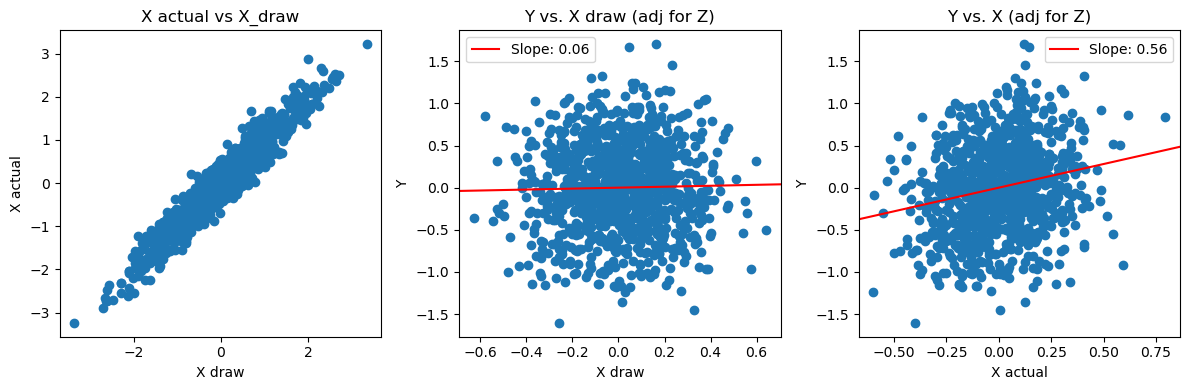

In [30]:
fig, axes = plt.subplots(1,3, figsize=(12, 4))
axes[0].scatter(X_draw, X)
axes[0].set_xlabel('X draw')
axes[0].set_ylabel('X actual')
axes[0].set_title('X actual vs X_draw')
axes[1].scatter(x_draw_adj_z, y_adj_z)
axes[1].set_xlabel('X draw')
axes[1].set_ylabel('Y')
axes[1].axline((0,0),slope=c1, color='red',label=f'Slope: {c1:.2f}')
axes[1].legend()
axes[1].set_title('Y vs. X draw (adj for Z)')
axes[2].scatter(x_adj_z, y_adj_z)
axes[2].set_xlabel('X actual')
axes[2].set_ylabel('Y')
axes[2].axline((0,0), slope=c2, color='red',label=f'Slope: {c2:.2f}')
axes[2].legend()
axes[2].set_title('Y vs. X (adj for Z)')
plt.tight_layout()